# Multiclass Classification: Linear classification with the MNIST data set

Author: Severin Angerpointner

**Abstract:** In this tutorial we will:
* Implement a layer of Adalines (neurons) for multiclass classification (here with the MNIST dataset of handwritten digits)
* Carry out the training
* Set an efficiency benchmark in number recognition for comparison to a multi-layer network (later)

In [1]:
import pandas as pd
import numpy as np
import gzip
import urllib
import matplotlib
import matplotlib.pyplot as plt

In [2]:
np.random.seed(15)

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 8]
matplotlib.rc("savefig", dpi=200)

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

<IPython.core.display.Javascript object>

In [10]:
# module for file access
import os.path

# global file name of our data source
digit_name = 'digits.csv'
label_name = 'labels.csv'

def fetch_digit_data(num_images):
    '''
    Download 'num_images' datasets (images plus labels) from the MNIST database and save them as .csv files for further use.
    (This might take a while for the whole dataset (60,000 images))
    '''
    #open gzip file from url and unzip it
    with gzip.open(
                  urllib.request.urlopen(
                      'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')   ) as bytestream:
        #read raw bytestring in buffer (images are 28 by 28 pixels)
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape((num_images, 28 * 28))
        #save images as num_images x 28*28 array
        np.savetxt(digit_name, data, fmt='%u',delimiter=',')
  
    #analogous for the labels
    with gzip.open(
                  urllib.request.urlopen(
                      'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')   ) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images)
        np.savetxt(label_name, data, fmt='%u',delimiter=',')
         
    return

# fetch data from internet source only if the file is not available locally
#fetch both and override old data to ensure same ordering
if not os.path.exists(digit_name) or not os.path.exists(label_name):
    fetch_digit_data(60000)

### Preparation of the multiclass data

The `prep_digit_data()` function has to be adapted as in the preceding implementations we only used two classes (eg. for iris data). The class labels will now be [0,9].

In [11]:
def prep_digit_data(df,dl):
    ''' 
    Fetches 28x28 digit images from the digit data and
    returns (X, Y), where X is a list of 28x28 arrays and Y a list of labels.
    '''
   
    # as feature we take the first 28 * 28 data entries,
    # which are the pixel brightness/darkness values (between 0 and 255)
    X = df.iloc[:, 0:784].values
    

    # read class labels: (labels already suitable indices, between 0 and 9)
    classes = dl.iloc[:].values 

    Y = []
    for i in range(len(classes)):
        Y.append(classes[i])
    
    # to make it more realistic, we randomize the data
    indices = np.random.permutation(len(X))
    X_rand = [X[i] for i in indices]
    Y_rand = [Y[i] for i in indices]

    # return the randomized lists as numpy arrays
    return np.array(X_rand,dtype=np.float64), np.array(Y_rand)

# This function is not in use (not revised yet)
def generate_random_data(num, n_features=2, n_classes=2):
    '''
    generates num items of radom data
    Y: an array of classes '-1 or 1'
    X: the corresponding data vectors
    '''
    
    # generate class labels -1 and 1
    Y = np.random.randint(n_classes, size=num)

    # generate the data on basis of which the distinction should be made
    X = np.random.rand(num, n_features)

    for n in range(num):
        phi = 2 * np.pi / (n_classes) * (Y[n] + (np.random.rand()-.5))
        v = np.array([np.cos(phi), np.sin(phi)])
        X[n, :] = v * np.random.rand() * 2

    return X, Y

### Multiclass Adaline

A multiclass Adaline is based on a layer of Adalines taking `n_in` input signals and distributing them to `n_out` output signals. The main difference to our preceding implementation of the Adaline is that now the weights are collected in a matrix `W_` instead of a vector.

In [12]:
class MultiClass: 

    def __init__(self, n_in, n_out):
        '''
        initialize class for `num` input signals
        '''

        self.n_in_ = n_in
        self.n_out_ = n_out

        self.W_ = np.zeros( (n_out, n_in) )
        self.b_ = np.zeros( (n_out, 1) )

        return
    
    def activation_input(self, X):
        '''
        calculate the activation input of the neuron
        '''
        return np.dot(X, self.W_.T) + self.b_.T
    
    def softmax(self,X):
        '''
        calculate activation function (softmax)
        '''
        exp = np.exp(self.activation_input(X))
        
        return exp / exp.sum(axis=1).reshape((X.shape[0],1))
    
    def crossentropy(self,X,Y):
        '''
        computes cross entropy for loss funcion
        '''      
        return -(1 / X.shape[0]) * (Y * np.log(self.softmax(X)) + (1 - Y) * np.log(1 - self.softmax(X))).sum()
    
    def classify(self, X):
        '''
        classify the data by sending the softmax output through an argmax
        '''
        return self.softmax(X).argmax(axis=1)

    def efficiency(self, X_test, Y_test): 
        '''
        compute the efficiency = 1 - number of misclassifications / number of data points
        '''

        err = 0
        
        # classify the test data
        Z = self.classify(X_test)
        for z, y in zip(Z, Y_test):
            err += int(z != y)

        return 1 - float(err) / len(X_test)

    def learn(self, X_train, Y_train, eta=0.01, epochs=1000):
        '''
        fit training data according to eta and n_iter
        and log the errors in errors_
        '''

        def label2vec(y):
            vecs = []
            for l in y:
                vec = np.zeros(self.n_out_)
                vec[l] = 1
                vecs.append(vec)
                
            return np.array(vecs)

        # we initialize two lists, each for the misclassifications and the cost function
        self.train_errors_ = []
        self.train_loss_ = []

        # for all the epochs
        for _ in range(epochs):
            # classify the traning features
            Z = self.classify(X_train)
            # count the misqualifications for the logging
            err = 0
            for z, y in zip(Z, Y_train):
                err += int(z != y)
            # ans save them in the list for later use
            self.train_errors_.append(err)
            
            #the commented part is the old (quadratic loss, argmax) update rule
            ''' 
            # compute the activation input of the entire traning features
            output = self.activation_input(X_train)
            # and then the deviation from the labels
            delta = label2vec(Y_train) - output
            # the following is an implmentation of the adaline update rule

            self.W_ += eta * np.dot(X_train.T, delta).T / len(X_train[:,0])
            self.b_ += eta * delta.sum(axis=0).reshape(self.n_out_,1) / len(X_train[:,0])
            '''            
            
            # here comes the softmax-argmax update using the cross-entropy loss function
            
            # compute row of derivatives for W (column-independent)
            deriv_W_ = np.empty_like(self.W_)
            #Compute alpha_j - y_j
            diff_ = label2vec(Y_train) - self.softmax(X_train)
            
            #update components of W_ 
            for j in range(deriv_W_.shape[0]):
                for k in range(deriv_W_.shape[1]):
                    deriv_W_[j,k] =  (diff_[:,j] * X_train[:,k]).sum(axis=0)
            
            self.W_ += eta * (1 / X_train.shape[0]) * np.array(deriv_W_)
            
            self.b_ += eta * (1 / X_train.shape[0]) * (diff_).sum(axis=0).reshape(self.b_.shape)
            
            
            # and finally, we record the loss function
            #for quadratic loss:
            #loss = (delta ** 2).sum() / 2.0
            
            #cross entropy loss function
            loss = self.crossentropy(X_train,label2vec(Y_train))
            # and save it for later use
            self.train_loss_.append(loss)

        return

    # the following two functions cannot be applied to the digit dataset
    def plot_data(self, X, Y, n_classes, m):

        # color map
        colors = matplotlib.cm.rainbow(np.linspace(0, 1, n_classes))

        # plot data with colors according to class labels
        for l, c in zip(range(n_classes), colors):
            xs = []
            for xi, yi in zip(X, Y):
                if yi == l:
                    xs.append(xi)
            xs = np.array(xs)
            plt.scatter(xs[:,0], xs[:,1], color=c, marker=m, edgecolor='black')

        return


    def plot_decision_regions(self, X, Y, X_train, Y_train, n_classes, resolution):

        # set up a 2d mesh of data points with resolution `resolution`
        x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
        x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 2

        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))

        # start new plot
        fig = plt.figure()
        axs = plt.gca()

        # make fictitious feature data out of the above 2d mesh
        x_mesh = np.array( [xx1.ravel(), xx2.ravel()] ).T
        # let the perceptron classify these features
        Z = self.classify(x_mesh)
        Z = Z.reshape(xx1.shape)

        # plot the mesh as contour plot
        axs.contourf(xx1, xx2, Z, alpha=0.1, cmap='prism')
        axs.set_xlim(xx1.min(), xx1.max())
        axs.set_ylim(xx2.min(), xx2.max())

        # plot training data with 'x's
        self.plot_data(X_train, Y_train, n_classes, 'x')
        # plot unknown data with 'o's
        self.plot_data(X, Y, n_classes, 'o')

        return

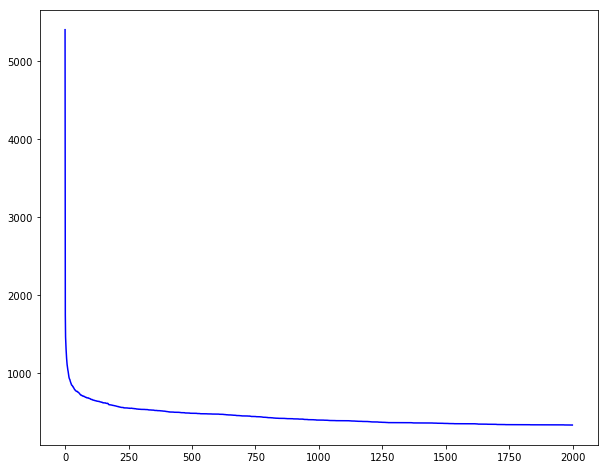

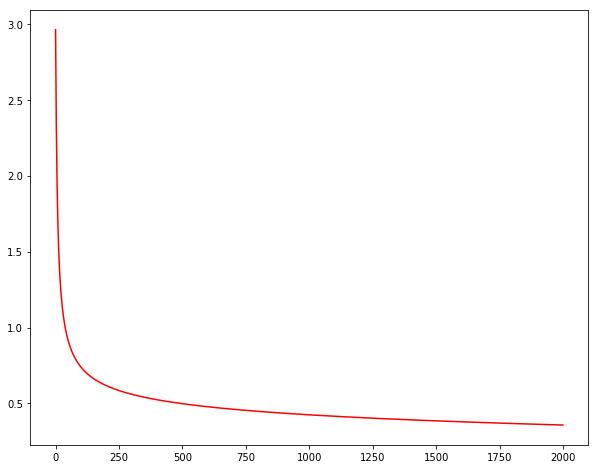

In [17]:
#read local data
df = pd.read_csv(digit_name, header=None)
dl = pd.read_csv(label_name,header=None)

X_all, Y_all = prep_digit_data(df,dl)

#rescale brightness values to prevent overflow in exp
X_all = X_all/255

# 28*28 pixels as input, 10 digit classes as output
n_features = 784
n_classes = 10

#initialize instance of neuron layer
mc = MultiClass(n_features,n_classes)

# training data - choose size of training/test set
train_samples = int( len(X_all) / 10 )
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]

# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# initialize W and b (zero by default)
mc.W_ = 0.0 * np.ones_like(mc.W_)
mc.b_ = 0.0 * np.ones_like(mc.b_)

mc.learn(X_train, Y_train, eta=0.25, epochs=2000)

#plot errors and loss function
plt.plot(mc.train_errors_,'b')
plt.show()
plt.plot(mc.train_loss_,'r')
plt.show()

Current efficiency on test set to beat: 0.906

Parameters: 10% of dataset as training data, 2000 epochs, eta = 0.25, brightness rescaling 1/255, W and b initialized as 0

In [18]:
#efficiencies of training
eff_train = mc.efficiency(X_train, Y_train)
eff_test = mc.efficiency(X, Y)
eff_all = mc.efficiency(X_all, Y_all)

print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

Efficiency (train) = 0.9443333333333334
Efficiency (test)  = 0.9068333333333334
Efficiency (all)   = 0.9105833333333333


System recognized 6
 Digit was 6


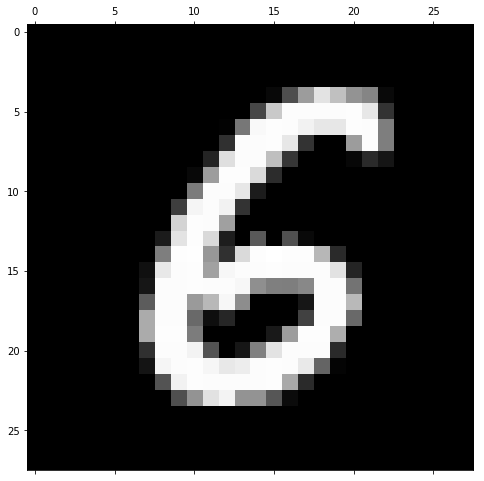

In [15]:
#Test with random digit

nmbr = np.random.randint(0,len(X))
sample = X[nmbr].reshape(28,28)

plt.matshow(sample, cmap='gray')
print("System recognized {}\n Digit was {}".format(mc.classify(X)[nmbr],Y[nmbr][0]))
plt.show()